In [1]:
import torch
from matplotlib import pyplot as plt
from matplotlib import rc
import numpy as np
import scipy.stats as stats
import xarray as xr

HOURS = 10

rc("font", **{"family": "Times"})
rc("text", usetex=True)
plt.rcParams['figure.dpi']= 300

test = torch.from_numpy(xr.open_dataset("test.nc").pr.values).reshape(-1, 1, HOURS, 64, 64)
samples = torch.load("samples.pt", map_location=torch.device('cpu'))

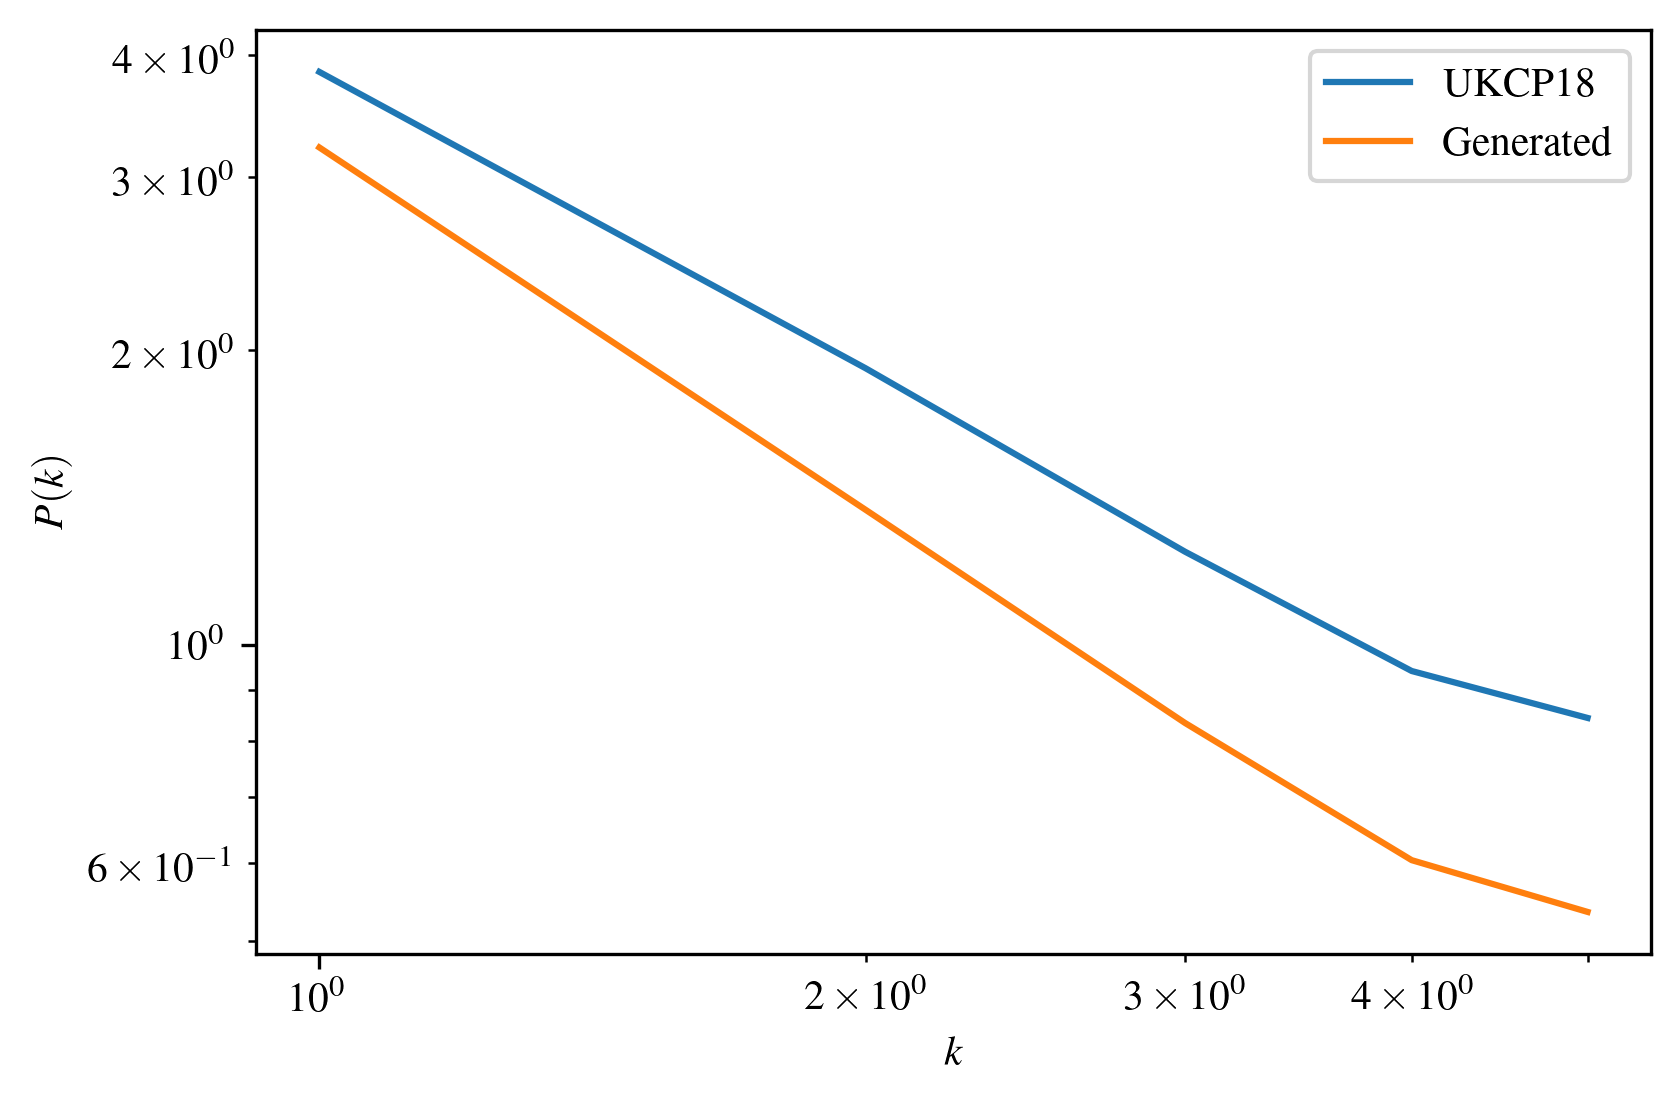

In [2]:
def psd_temporal(frames):
    pixels_in_time = frames.reshape(frames.shape[0], HOURS, -1).transpose(1, 2).reshape(-1, HOURS)

    fourier_image = np.fft.fftn(pixels_in_time, axes = (1,))
    fourier_amplitudes = np.abs(fourier_image) ** 2

    kfreq = np.fft.fftfreq(HOURS) * HOURS
    knrm = np.abs(kfreq)

    kbins = np.arange(0.5, HOURS // 2 + 1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])

    Abins, _, _ = stats.binned_statistic( 
        knrm, # Need to check this
        fourier_amplitudes,
        statistic = "mean",
        bins = kbins
    )
    Abins = np.mean(Abins, axis = 0)

    # Should there be a multiplicative term here?
    # Abins *= np.array([2 * np.pi * k ** 2 for k in kvals])

    return kvals, Abins

kvals_test, Abins_test = psd_temporal(test)
kvals_sample, Abins_sample = psd_temporal(samples)

plt.figure(figsize=(6, 4))
plt.loglog(kvals_test, Abins_test, label="UKCP18")
plt.loglog(kvals_sample, Abins_sample, label="Generated")
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.legend()
plt.show()